In [1]:
import torch
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用第1块GPU（从0开始）
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import torch.nn.functional as F
import torchvision
import numpy as np
from math import *
import matplotlib.pyplot as plt
from torch.autograd import Variable
from IPython import display
import torch.utils.data as Data
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# %matplotlib notebook
from matplotlib import cm
from scipy.linalg import block_diag
import datetime
from torch.nn.utils import *
from Network_FDD import *

In [2]:
def train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE):#N代表路径数，若N为-1则代表
    shoulian = np.zeros(EPOCH)
    snr =  10**(SNR_dB/10)/K
    parm_set = [Nc,Nt,Nr,snr,B,K]
        
    H_train_1 = torch.load('data/H_train_UPA'+str(N)+'Lp_1.pt')
    H_train_1 = H_train_1[:,0:K,:,:]
    H_train_2 = torch.load('data/H_train_UPA'+str(N)+'Lp_2.pt')
    H_train_2 = H_train_2[:,0:K,:,:]
    H_train = torch.cat([H_train_1,H_train_2],0)
    H_train_1 = 0
    H_train_2 = 0
    print(H_train.shape)
    H_test = torch.load('data/H_test_UPA'+str(N)+'Lp.pt')
    H_test = H_test[:,0:K,:,:]
    
    net_US = DNN_US_RF_OFDM(parm_set).cuda()
    net_BS = DNN_BS_hyb_OFDM(parm_set).cuda()

    print(net_BS)
    print(net_US)
    optimizer_US = torch.optim.Adam(net_US.parameters(),lr=0.001)
    scheduler_US = torch.optim.lr_scheduler.MultiStepLR(optimizer_US,  milestones = [100,150], gamma = 0.6, last_epoch=-1)   

    optimizer_BS = torch.optim.Adam(net_BS.parameters(),lr=0.001)
    scheduler_BS = torch.optim.lr_scheduler.MultiStepLR(optimizer_BS,  milestones = [100,150], gamma = 0.6, last_epoch=-1)
    
    loss_func1 = MyLoss_OFDM()
    loss_func1 = loss_func1.cuda()

    
    best_SE = 0
    torch_dataset_train = Data.TensorDataset(H_train)
    loader_train = Data.DataLoader(
        dataset=torch_dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=True,#训练时随机打乱数据
        num_workers=0,#每次用两个进程提取
    )
    
    torch_dataset_test = Data.TensorDataset(H_test)
    loader_test = Data.DataLoader(
        dataset=torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True,#训练时随机打乱数据
        num_workers=0,#每次用两个进程提取
    )
    start = datetime.datetime.now()
    for epoch in range(EPOCH):
        train_SE  = 0
        num_train = 0
        test_SE   = 0
        num_test  = 0
        for step,[b_x] in enumerate(loader_train):
            num_train = num_train + 1
            net_US.train() 
            net_BS.train() #训练模式
            b_x = b_x.cuda()
            num = b_x.shape[0]
            out1 = torch.zeros([num,B*K])
            out1 = out1.cuda()
            for i in range(K):
                out1k = net_US(b_x[:,i,:,:],parm_set)
                out1[:,i*B:(i*B+B)] = out1k
            out2 = net_BS(out1,parm_set)
            loss = loss_func1(b_x,out2,parm_set)
            train_SE = train_SE - loss
            optimizer_US.zero_grad()
            optimizer_BS.zero_grad()

            loss.backward()
            optimizer_US.step()
            optimizer_BS.step()
        train_SE = train_SE/num_train
        scheduler_US.step()
        scheduler_BS.step()

        net_US.eval() 
        net_BS.eval() 
        with torch.no_grad():
            for step,[b_x] in enumerate(loader_test):
                num_test = num_test + 1
                net_US.eval() 
                net_BS.eval() #验证模式
                b_x = b_x.cuda()
                num = b_x.shape[0]
                out1 = torch.zeros([num,B*K])
                out1 = out1.cuda()
                for i in range(K):
                    out1k = net_US(b_x[:,i,:,:],parm_set)
                    out1[:,i*B:(i*B+B)] = out1k
                out2 = net_BS(out1,parm_set)
                loss = loss_func1(b_x,out2,parm_set)
                test_SE = test_SE - loss
            test_SE = test_SE/num_test

        time0 =  datetime.datetime.now()-start
        print('Epoch:',epoch,'time',time0,'train SE %.3f' % train_SE.cpu(),'test SE %.3f' % test_SE.cpu()) 
        start = datetime.datetime.now()

        if test_SE > best_SE:
            best_SE = test_SE
            torch.save(net_US, './net_US_OFDM_'+str(B)+'B'+str(N)+'Lp'+str(L)+'L'+str(K)+'K'+'_8L_UPA.pth')
            torch.save(net_BS, './net_BS_OFDM_'+str(B)+'B'+str(N)+'Lp'+str(L)+'L'+str(K)+'K'+'_8L_UPA.pth')   
            print('Model saved!')
        shoulian[epoch] = test_SE.cpu()
    print('The best SE is: %.3f' % best_SE.cpu())
    print(shoulian)

In [3]:
def test(Nc,N_net,N_data,Nt,B,Nr,L,SNR_dB,K,BATCH_SIZE):
    #N_net表示网络训练时的路径数，-1代表随即路径 N_data代表测试时的路径
    snr =  10**(SNR_dB/10)/K
    parm_set = [Nc,Nt,Nr,snr,B,K]
    
    
    H_test = torch.load('data/H_test_UPA'+str(N_data)+'Lp.pt')
    H_test = H_test[:,0:K,:,:]
    
    net_US = DNN_US_RF_OFDM(parm_set).cuda()
    net_BS = DNN_BS_hyb_OFDM(parm_set).cuda()
    net_US = torch.load('./net_US_OFDM_'+str(B)+'B'+str(N_net)+'Lp'+str(L)+'L'+str(K)+'K'+'_8L_UPA.pth')
    net_BS = torch.load('./net_BS_OFDM_'+str(B)+'B'+str(N_net)+'Lp'+str(L)+'L'+str(K)+'K'+'_8L_UPA.pth')
#     print(net_BS)
#     print(net_US)
    
    loss_func1 = MyLoss_OFDM()
    loss_func1 = loss_func1.cuda()


    
    torch_dataset_test = Data.TensorDataset(H_test)
    loader_test = Data.DataLoader(
        dataset=torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True,#训练时随机打乱数据
        num_workers=0,#每次用两个进程提取
    )
    num_test = 0
    with torch.no_grad():
        test_SE = 0
        for step,[b_x] in enumerate(loader_test):
            num_test = num_test + 1
            net_US.eval() 
            net_BS.eval() #验证模式
            b_x = b_x.cuda()
            num = b_x.shape[0]
            out1 = torch.zeros([num,B*K])
            out1 = out1.cuda()
            for i in range(K):
                out1k = net_US(b_x[:,i,:,:],parm_set)
                out1[:,i*B:(i*B+B)] = out1k
            out2 = net_BS(out1,parm_set)
            loss = loss_func1(b_x,out2,parm_set)
            test_SE = test_SE - loss
        test_SE = test_SE/num_test
    print('test SE %.3f' % test_SE.cpu())
    return test_SE.cpu()

# L=8, B=8...128

In [2]:
Nc = 32 #number of subcarriers
N = 2   # Number of paths
Nt = 64 # Number of Antennas at the BS
Nr = 1  # Number of Antennas at the UE
# B = 30

L = 8   # number of pilot OFDM symbols
SNR_dB = 10  # SNR
K = 2   # number of UEs
snr =  10**(SNR_dB/10)/K

BATCH_SIZE = 512
EPOCH = 180

In [26]:
B = 1  #feedback bits
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=2, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:13.319429 train SE 4.189 test SE 3.785
Model saved!
Epoch: 2 time 0:01:12.986178 train SE 4.070 test SE 4.605
Model saved!
Epoch: 3 time 0:01:11.549747 train SE 4.339 test SE 4.435
Epoch: 4 time 0:01:06.390784 train SE 4.203 test SE 4.119
Epoch: 5 time 0:01:08.970144 train SE 4.267 test SE 4.311
Epoch: 6 time 0:01:07.061429 train SE 4.100 test SE 4.282
Epoch: 7 time 0:01:09.845692 train SE 4.300 test SE 4.200
Epoch: 8 time 0:01:13.154563 train SE 3.995 test SE 3.910
Epoch: 9 time 0:01:10.319057 train SE 4.202 test SE 4.682
Model saved!
Epoch: 10 time 0:01:22.018251 train SE 4.677 test SE 4.632
Epoch: 11 time 0:01:23.688065 train SE 4.036 test SE 3.876
Epoch: 12 time 0:01:23.708071 train SE 4.443 test SE 4.665
Epoch: 13 time 0:01:23.957963 train SE 4.630 test SE 4.639
Epoch: 14 time 0:01:24.631750 train SE 4.439 test SE 4.503
Epoch: 15 time 0:01:22.460855 train SE 4.571 test SE 4.580
Epoch: 16 time 0:01:24.745730 train SE 4.533 test SE 4.517
Epoch: 17 tim

In [27]:
B = 3
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=6, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:24.386680 train SE 4.928 test SE 4.491
Epoch: 2 time 0:01:24.103874 train SE 4.976 test SE 4.594
Epoch: 3 time 0:01:24.949124 train SE 4.739 test SE 5.440
Model saved!
Epoch: 4 time 0:01:24.297893 train SE 4.527 test SE 4.692
Epoch: 5 time 0:01:24.041667 train SE 4.678 test SE 4.804
Epoch: 6 time 0:01:22.382077 train SE 4.928 test SE 5.069
Epoch: 7 time 0:01:23.421213 train SE 5.481 test SE 5.751
Model saved!
Epoch: 8 time 0:01:23.257191 train SE 4.805 test SE 4.904
Epoch: 9 time 0:01:26.232788 train SE 4.991 test SE 3.899
Epoch: 10 time 0:01:25.270723 train SE 5.356 test SE 5.389
Epoch: 11 time 0:01:25.477251 train SE 4.572 test SE 4.285
Epoch: 12 time 0:01:24.930193 train SE 4.281 test SE 4.896
Epoch: 13 time 0:01:25.236519 train SE 4.795 test SE 5.015
Epoch: 14 time 0:01:23.131937 train SE 5.039 test SE 4.926
Epoch: 15 time 0:01:23.742353 train SE 4.981 test SE 5.071
Epoch: 16 time 0:01:24.561643 train SE 5.011 test SE 5.161
Epoch: 17 time 0:01:24.952

In [28]:
B = 5
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=10, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:27.061063 train SE 5.516 test SE 6.243
Model saved!
Epoch: 2 time 0:01:23.472120 train SE 6.421 test SE 6.585
Model saved!
Epoch: 3 time 0:01:27.385652 train SE 6.732 test SE 7.008
Model saved!
Epoch: 4 time 0:01:23.105067 train SE 7.088 test SE 7.230
Model saved!
Epoch: 5 time 0:01:26.819072 train SE 7.040 test SE 7.107
Epoch: 6 time 0:01:27.670501 train SE 6.951 test SE 7.069
Epoch: 7 time 0:01:24.903476 train SE 7.026 test SE 7.178
Epoch: 8 time 0:01:23.263196 train SE 6.724 test SE 6.098
Epoch: 9 time 0:01:26.747427 train SE 6.217 test SE 6.419
Epoch: 10 time 0:01:27.301478 train SE 6.675 test SE 6.582
Epoch: 11 time 0:01:26.368295 train SE 6.701 test SE 6.765
Epoch: 12 time 0:01:25.371853 train SE 6.167 test SE 6.387
Epoch: 13 time 0:01:23.203911 train SE 6.089 test SE 6.045
Epoch: 14 time 0:01:26.239257 train SE 5.825 test SE 5.680
Epoch: 15 time 0:01:23.135960 train SE 6.014 test SE 6.342
Epoch: 16 time 0:01:24.793034 train SE 6.377 test SE 5.908


In [29]:
B = 8
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=16, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:26.734897 train SE 5.037 test SE 5.578
Model saved!
Epoch: 2 time 0:01:26.787290 train SE 6.491 test SE 6.891
Model saved!
Epoch: 3 time 0:01:26.447252 train SE 7.032 test SE 7.058
Model saved!
Epoch: 4 time 0:01:26.264545 train SE 7.055 test SE 7.112
Model saved!
Epoch: 5 time 0:01:25.455357 train SE 7.081 test SE 7.243
Model saved!
Epoch: 6 time 0:01:23.314053 train SE 7.197 test SE 7.210
Epoch: 7 time 0:01:23.404806 train SE 7.401 test SE 7.643
Model saved!
Epoch: 8 time 0:01:23.138498 train SE 7.776 test SE 7.816
Model saved!
Epoch: 9 time 0:01:24.176828 train SE 7.890 test SE 7.916
Model saved!
Epoch: 10 time 0:01:23.452696 train SE 8.035 test SE 8.009
Model saved!
Epoch: 11 time 0:01:26.855123 train SE 8.077 test SE 7.989
Epoch: 12 time 0:01:23.440706 train SE 8.201 test SE 8.104
Model saved!
Epoch: 13 time 0:01:26.199922 train SE 8.240 test SE 8.239
Model saved!
Epoch: 14 time 0:01:23.257612 train SE 8.320 test SE 8.304
Model saved!
Epoch: 15 time

In [30]:

B = 16
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=32, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:25.004606 train SE 6.767 test SE 7.384
Model saved!
Epoch: 2 time 0:01:24.078100 train SE 7.654 test SE 8.097
Model saved!
Epoch: 3 time 0:01:22.987244 train SE 8.236 test SE 8.577
Model saved!
Epoch: 4 time 0:01:23.102617 train SE 8.489 test SE 8.679
Model saved!
Epoch: 5 time 0:01:24.099013 train SE 8.651 test SE 8.808
Model saved!
Epoch: 6 time 0:01:23.402430 train SE 8.703 test SE 8.856
Model saved!
Epoch: 7 time 0:01:26.141999 train SE 8.743 test SE 8.894
Model saved!
Epoch: 8 time 0:01:25.814849 train SE 8.481 test SE 8.417
Epoch: 9 time 0:01:24.879911 train SE 8.386 test SE 8.190
Epoch: 10 time 0:01:29.152001 train SE 8.446 test SE 8.548
Epoch: 11 time 0:01:23.507045 train SE 8.530 test SE 8.672
Epoch: 12 time 0:01:23.372888 train SE 8.684 test SE 8.936
Model saved!
Epoch: 13 time 0:01:22.994481 train SE 8.945 test SE 9.124
Model saved!
Epoch: 14 time 0:01:24.315745 train SE 8.988 test SE 9.125
Model saved!
Epoch: 15 time 0:01:29.048164 train SE 9

In [31]:
B = 24
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=48, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:23.965753 train SE 6.216 test SE 6.897
Model saved!
Epoch: 2 time 0:01:23.775422 train SE 7.405 test SE 7.900
Model saved!
Epoch: 3 time 0:01:22.472863 train SE 8.197 test SE 8.468
Model saved!
Epoch: 4 time 0:01:20.060849 train SE 8.657 test SE 8.933
Model saved!
Epoch: 5 time 0:01:24.212206 train SE 9.062 test SE 9.213
Model saved!
Epoch: 6 time 0:01:24.282957 train SE 9.287 test SE 9.378
Model saved!
Epoch: 7 time 0:01:23.535898 train SE 9.441 test SE 9.481
Model saved!
Epoch: 8 time 0:01:23.783840 train SE 9.587 test SE 9.666
Model saved!
Epoch: 9 time 0:01:23.512017 train SE 9.716 test SE 9.792
Model saved!
Epoch: 10 time 0:01:23.930249 train SE 9.826 test SE 9.845
Model saved!
Epoch: 11 time 0:01:23.534443 train SE 9.909 test SE 9.963
Model saved!
Epoch: 12 time 0:01:24.058706 train SE 9.997 test SE 10.062
Model saved!
Epoch: 13 time 0:01:25.346585 train SE 10.081 test SE 10.093
Model saved!
Epoch: 14 time 0:01:24.103894 train SE 10.151 test SE 10.

In [32]:
B = 32
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=64, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:22.278349 train SE 5.929 test SE 6.345
Model saved!
Epoch: 2 time 0:01:24.148443 train SE 6.780 test SE 7.319
Model saved!
Epoch: 3 time 0:01:26.009592 train SE 7.582 test SE 7.841
Model saved!
Epoch: 4 time 0:01:26.295075 train SE 8.142 test SE 8.378
Model saved!
Epoch: 5 time 0:01:26.050784 train SE 8.563 test SE 8.659
Model saved!
Epoch: 6 time 0:01:26.319486 train SE 8.819 test SE 8.950
Model saved!
Epoch: 7 time 0:01:26.491786 train SE 9.061 test SE 9.217
Model saved!
Epoch: 8 time 0:01:24.677029 train SE 9.261 test SE 9.358
Model saved!
Epoch: 9 time 0:01:27.316923 train SE 9.407 test SE 9.461
Model saved!
Epoch: 10 time 0:01:25.944487 train SE 9.538 test SE 9.592
Model saved!
Epoch: 11 time 0:01:27.257030 train SE 9.632 test SE 9.694
Model saved!
Epoch: 12 time 0:01:26.647319 train SE 9.702 test SE 9.785
Model saved!
Epoch: 13 time 0:01:26.565357 train SE 9.781 test SE 9.830
Model saved!
Epoch: 14 time 0:01:29.230620 train SE 9.834 test SE 9.922
M

In [33]:
B = 48
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=96, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:25.553138 train SE 6.710 test SE 7.412
Model saved!
Epoch: 2 time 0:01:25.470861 train SE 7.949 test SE 8.446
Model saved!
Epoch: 3 time 0:01:26.681168 train SE 8.672 test SE 8.926
Model saved!
Epoch: 4 time 0:01:26.402294 train SE 9.093 test SE 9.287
Model saved!
Epoch: 5 time 0:01:28.420341 train SE 9.382 test SE 9.530
Model saved!
Epoch: 6 time 0:01:26.630614 train SE 9.559 test SE 9.618
Model saved!
Epoch: 7 time 0:01:26.771787 train SE 9.711 test SE 9.782
Model saved!
Epoch: 8 time 0:01:26.569963 train SE 9.815 test SE 9.914
Model saved!
Epoch: 9 time 0:01:26.049148 train SE 9.928 test SE 10.085
Model saved!
Epoch: 10 time 0:01:27.696845 train SE 10.093 test SE 10.188
Model saved!
Epoch: 11 time 0:01:26.018314 train SE 10.173 test SE 10.289
Model saved!
Epoch: 12 time 0:01:26.459651 train SE 10.257 test SE 10.321
Model saved!
Epoch: 13 time 0:01:26.614324 train SE 10.335 test SE 10.424
Model saved!
Epoch: 14 time 0:01:26.768327 train SE 10.422 test 

In [34]:
B = 64
train(Nc,N,Nt,B,Nr,L,SNR_dB,K,EPOCH,BATCH_SIZE)

torch.Size([204800, 2, 32, 128])
DNN_BS_hyb_OFDM(
  (DQL): DequantizationLayer()
  (FC1): Linear(in_features=128, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish1): Mish()
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish2): Mish()
  (FC3): Linear(in_features=1024, out_features=384, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mish3): Mish()
  (res1): RES_BLOCK(
    (conv1): Sequential(
      (0): Conv2d(8, 256, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (conv2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNN_US_RF_OFDM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RES_BLOCK. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Mish. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type QuantizationLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checke

Model saved!
Epoch: 1 time 0:01:25.761685 train SE 6.064 test SE 6.077
Model saved!
Epoch: 2 time 0:01:25.359670 train SE 6.131 test SE 6.218
Model saved!
Epoch: 3 time 0:01:26.371868 train SE 6.494 test SE 6.785
Model saved!
Epoch: 4 time 0:01:26.427826 train SE 7.092 test SE 7.401
Model saved!
Epoch: 5 time 0:01:27.222767 train SE 7.777 test SE 8.105
Model saved!
Epoch: 6 time 0:01:26.459098 train SE 8.264 test SE 8.471
Model saved!
Epoch: 7 time 0:01:26.562913 train SE 8.614 test SE 8.801
Model saved!
Epoch: 8 time 0:01:26.621204 train SE 8.923 test SE 9.084
Model saved!
Epoch: 9 time 0:01:27.212648 train SE 9.170 test SE 9.327
Model saved!
Epoch: 10 time 0:01:25.432812 train SE 9.402 test SE 9.524
Model saved!
Epoch: 11 time 0:01:26.694608 train SE 9.595 test SE 9.709
Model saved!
Epoch: 12 time 0:01:26.794248 train SE 9.785 test SE 9.844
Model saved!
Epoch: 13 time 0:01:26.860508 train SE 9.901 test SE 9.944
Model saved!
Epoch: 14 time 0:01:26.641289 train SE 10.013 test SE 10.010

In [10]:
for B in [1,3,5,8,16,24,32,48,64]:
    test(Nc,N,N,Nt,B,Nr,L,SNR_dB,K,BATCH_SIZE)

D:\Self_installed_software\Anaconda3\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\Self_installed_software\Anaconda3\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\Self_installed_software\Anaconda3\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by a

test SE 4.677
test SE 6.060
test SE 7.230
test SE 9.961
test SE 10.745
test SE 11.334
test SE 11.521
test SE 11.304
test SE 11.645


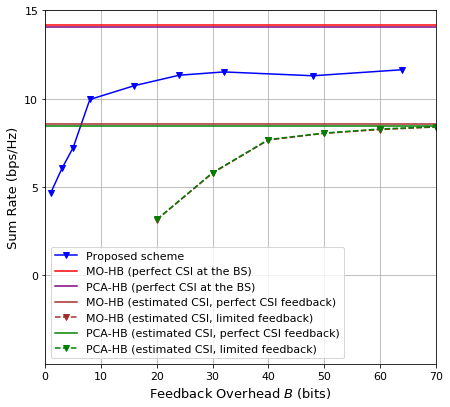

In [6]:
B_set = [1,3,5,8,16,24,32,48,64]
SE_list_DNN = [ 4.677,  6.060,  7.230,  9.961, 10.745,11.334 , 11.521 , 11.304, 11.645]

SE_list_percsi_MO = np.ones(8)*14.19122653
B_set2 = [0,10,20,30,40,50,60,70]
SE_OMP_set_MO = np.ones(8)*8.55466791
B_set3 = [20,30,40,50,60,70]
SE_OMP_QUAN_set_MO = [3.15252835,5.79277314,7.66800098,8.04520523,8.25775114,8.40329873]

SE_list_percsi_PCA = np.ones(8)*14.04247462 
SE_OMP_set_PCA = np.ones(8)*8.4357455 
SE_OMP_QUAN_set_PCA = [3.17091409,5.82117721,7.69306492,8.05957222,8.29079286,8.42041856]
# %matplotlib notebook

plt.figure(figsize=(7, 6.5))
ax = plt.subplot(111)
# 设置刻度字体大小
fs = 11
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
# 设置坐标标签字体大小
ax.set_xlabel(..., fontsize=fs+2)
ax.set_ylabel(..., fontsize=fs+2)

plt.plot(B_set,SE_list_DNN,label = "Proposed scheme",marker='v',color = 'blue',linewidth='1.5')
plt.plot(B_set2,SE_list_percsi_MO,label = "MO-HB (perfect CSI at the BS)",color = 'red',linewidth='1.5')
plt.plot(B_set2,SE_list_percsi_PCA,label = "PCA-HB (perfect CSI at the BS)",color = 'purple',linewidth='1.5')
plt.plot(B_set2,SE_OMP_set_MO,label = "MO-HB (estimated CSI, perfect CSI feedback)",color = 'brown',linewidth='1.5')
plt.plot(B_set3,SE_OMP_QUAN_set_MO,label = "MO-HB (estimated CSI, limited feedback)",marker='v',color = 'brown',linewidth='1.5',linestyle = "--")


plt.plot(B_set2,SE_OMP_set_PCA,label = "PCA-HB (estimated CSI, perfect CSI feedback)",color = 'green',linewidth='1.5')
plt.plot(B_set3,SE_OMP_QUAN_set_PCA,label = "PCA-HB (estimated CSI, limited feedback)",marker='v',color = 'green',linewidth='1.5',linestyle = "--")

plt.grid()
# plt.title('K=2 Lp=2 L=8 UPA8*8')
plt.xlabel('Feedback Overhead $B$ (bits)') 
plt.ylabel('Sum Rate (bps/Hz)')
plt.ylim((-5,15))
plt.xlim((0,70))
plt.yticks([0, 5, 10,15],['0', '5', '10','15'])
plt.legend(loc="best")
plt.legend(fontsize=fs)
#plt.set_yticks = [0, 5, 10,15]
#plt.set_yticklabels = ['0', '5', '10','15']
plt.savefig('fig11_a.pdf')
plt.savefig('fig11_a.png')